In [13]:
import yfinance as yf
from datetime import date
import pandas as pd
import numpy as np
from sklearn import metrics
from math import sqrt
import matplotlib.pyplot as plt

In [14]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [15]:
# Input dari pengguna untuk simbol saham
symbol = input("Masukkan simbol saham (misalnya 'AAPL'): ")
start_date = date(2018, 1, 1)
end_date = date(2024, 2, 1)

# Mengunduh data saham dari Yahoo Finance # Menambahkan kolom tanggal sebagai indeks
data = yf.download(symbol, start=start_date, end=end_date)
data.reset_index(inplace=True)

# Input dari pengguna untuk fitur yang akan digunakan
input_feat = input("Masukkan fitur yang akan digunakan ('Adj Close','Close'): ")


data = data[["Date", input_feat]]# Memilih kolom tanggal dan fitur yang akan digunakan
data

c:\Users\kevin\miniconda3\envs\tf\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


,Date,Close
0,2018-01-01,3309.033691
1,2018-01-02,3299.943115
2,2018-01-03,3281.761475
3,2018-01-04,3227.217041
4,2018-01-05,3263.580078
...,...,...
1405,2023-08-25,5600.000000
1406,2023-08-28,5550.000000
1407,2023-08-29,5600.000000
1408,2023-08-30,5525.000000


In [16]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[input_feat].values.reshape(-1, 1))

In [17]:
# Pembagian data menjadi data latih dan data uji
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size, :], scaled_data[train_size:, :]

In [18]:
# Persiapan Create Sequences LSTM
def create_sequences(data, sequence_length):
    sequences = []
    target = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        target.append(data[i+sequence_length])
    return np.array(sequences), np.array(target)

In [19]:
sequence_length = 1 
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

In [20]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(64))
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 128)            66560     
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


In [21]:
cp3 = ModelCheckpoint('../model/model2/', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

optimizer = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2, callbacks=[cp3, early_stopping], validation_data=(X_test, y_test))

Epoch 1/100


INFO:tensorflow:Assets written to: ../model/model2\assets


INFO:tensorflow:Assets written to: ../model/model2\assets


36/36 - 11s - loss: 0.1170 - accuracy: 8.8731e-04 - val_loss: 0.0878 - val_accuracy: 0.0249 - 11s/epoch - 294ms/step
Epoch 2/100


INFO:tensorflow:Assets written to: ../model/model2\assets


INFO:tensorflow:Assets written to: ../model/model2\assets


36/36 - 8s - loss: 0.0106 - accuracy: 8.8731e-04 - val_loss: 0.0498 - val_accuracy: 0.0249 - 8s/epoch - 218ms/step
Epoch 3/100


INFO:tensorflow:Assets written to: ../model/model2\assets


INFO:tensorflow:Assets written to: ../model/model2\assets


36/36 - 8s - loss: 0.0069 - accuracy: 8.8731e-04 - val_loss: 0.0231 - val_accuracy: 0.0249 - 8s/epoch - 221ms/step
Epoch 4/100


INFO:tensorflow:Assets written to: ../model/model2\assets


INFO:tensorflow:Assets written to: ../model/model2\assets


36/36 - 9s - loss: 0.0042 - accuracy: 8.8731e-04 - val_loss: 0.0085 - val_accuracy: 0.0249 - 9s/epoch - 261ms/step
Epoch 5/100


INFO:tensorflow:Assets written to: ../model/model2\assets


INFO:tensorflow:Assets written to: ../model/model2\assets


36/36 - 8s - loss: 0.0020 - accuracy: 8.8731e-04 - val_loss: 9.0557e-04 - val_accuracy: 0.0249 - 8s/epoch - 227ms/step
Epoch 6/100
36/36 - 0s - loss: 8.2409e-04 - accuracy: 8.8731e-04 - val_loss: 0.0013 - val_accuracy: 0.0249 - 416ms/epoch - 12ms/step
Epoch 7/100
36/36 - 0s - loss: 5.1406e-04 - accuracy: 8.8731e-04 - val_loss: 0.0020 - val_accuracy: 0.0249 - 399ms/epoch - 11ms/step
Epoch 8/100
Restoring model weights from the end of the best epoch: 5.
36/36 - 0s - loss: 4.8496e-04 - accuracy: 8.8731e-04 - val_loss: 0.0028 - val_accuracy: 0.0249 - 459ms/epoch - 13ms/step
Epoch 8: early stopping


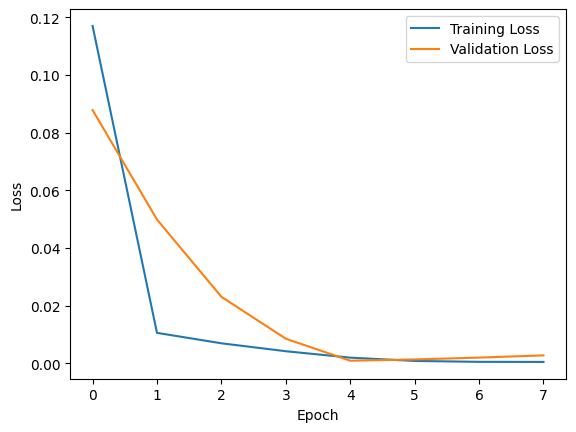

In [22]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

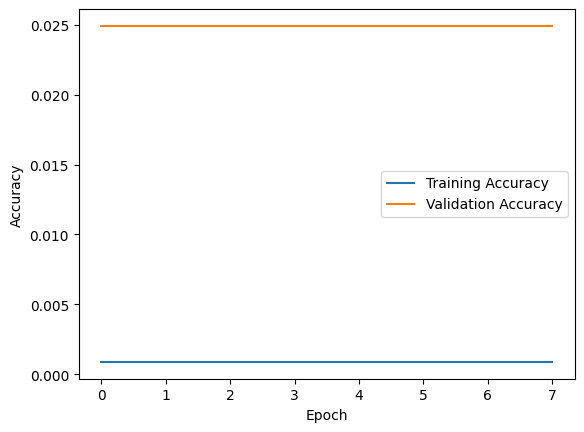

In [23]:
# Misalnya, jika Anda memiliki metrik akurasi:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
# Evaluasi model pada data uji
loss = model.evaluate(X_test, y_test)
print("Loss di data uji:", loss)

print("Loss di data uji:", loss)
predict = model.predict(X_test)
# print(predict)

9/9 [==============================] - 0s 6ms/step - loss: 9.0557e-04 - accuracy: 0.0249
Loss di data uji: [0.0009055720875039697, 0.024911031126976013]
Loss di data uji: [0.0009055720875039697, 0.024911031126976013]
9/9 [==============================] - 1s 4ms/step


In [27]:

print("-"*50, " Metric ","-"*50)
print('RMSE : ',sqrt(metrics.mean_squared_error(y_test,predict)))
print('MSE  :  ',metrics.mean_squared_error(y_test,predict))
print('MAE  :  ',metrics.mean_absolute_error(y_test,predict))
print("-"*26, " Mengecek Apakah Nilainya Overfit atau tidak ","-"*26)


--------------------------------------------------  Metric  --------------------------------------------------
RMSE :  0.030092724507402045
MSE  :   0.0009055720682783957
MAE  :   0.025793596820936605
--------------------------  Mengecek Apakah Nilainya Overfit atau tidak  --------------------------


In [26]:
# Simpan model
model.save("../home-page-stock-prediction/lstm_model2.keras")
print("Successfully saved model")